Same as the Proof of Concept but running against data from Ethan

In [116]:
import numpy as np
from scipy import ndimage
import pywt
import pandas as pd

In [117]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [118]:
data = pd.read_csv('dgaia_ret_ii.txt')
d_data = pd.read_csv('dgaia_ret_ii_dwarf.txt')
r_data = pd.read_csv('dgaia_ret_ii_rest.txt')

In [119]:
full_field = np.c_[data['ra'].as_matrix(), data['dec'].as_matrix(), data['pmra'].as_matrix(), data['pmdec'].as_matrix()]

/afs/slac.stanford.edu/u/ki/swmclau2/.local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [120]:
print full_field.shape

(9903, 4)


In [121]:
full_field.shape

(9903, 4)

In [122]:
full_field = full_field[np.all(~np.isnan(full_field), axis = 1)]

In [123]:
full_field.shape

(8624, 4)

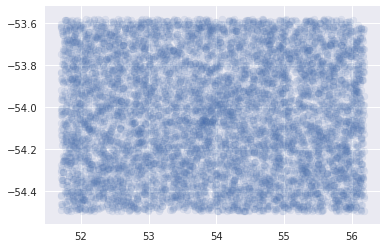

In [124]:
plt.scatter(full_field[:,0], full_field[:,1], alpha = 0.1)

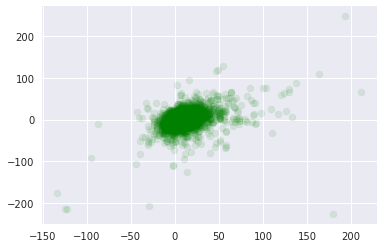

In [125]:
plt.scatter(full_field[:,2], full_field[:,3], alpha = 0.1, color = 'g')

In [126]:
np.min(full_field, axis = 0)

array([  51.70085526,  -54.49810791, -133.99732971, -225.39024353])

In [127]:
np.max(full_field, axis = 0)

array([ 56.18374252, -53.57997131, 211.52005005, 247.09980774])

In [128]:
n_pos, n_vel = 61, 61
ra_min, ra_max = 51.6, 56.2
dec_min, dec_max =-54.5, -53.5
vra_min, vra_max = -10, 10
vdec_min, vdec_max =-10, 20
field_image, _ = np.histogramdd(full_field,\
                            bins=(np.linspace(ra_min, ra_max, n_pos),
                                  np.linspace(dec_min, dec_max, n_pos), 
                                  np.linspace(vra_min, vra_max, n_vel),
                                  np.linspace(vdec_min, vdec_max, n_vel) ) )

In [129]:
field_image.shape, field_image.nbytes/(1024**2)

((60, 60, 60, 60), 98)

In [130]:
def convert_max_to_orig_coord(max_pos, wavelet_size):
    upscaled_pos = max_pos*n_pos*1.0/wavelet_size #TODO diff bins in vel and pos
    orig_coord = np.zeros_like(max_pos)
    orig_coord[0] = (ra_max-ra_min)*upscaled_pos[0]/n_pos + ra_min
    orig_coord[1] = (dec_max-dec_min)*upscaled_pos[1]/n_pos+dec_min
    orig_coord[2] = (vra_max-vra_min)*upscaled_pos[2]/n_pos + vra_min
    orig_coord[3] = (vdec_max-vdec_min)*upscaled_pos[3]/n_pos + vdec_min
    return orig_coord

In [131]:
def plot(im):
    max_pos = ndimage.measurements.maximum_position(np.abs(im))
    print convert_max_to_orig_coord(np.array(max_pos), im.shape[0])
    plt.subplot(121)
    plt.imshow(im.sum(axis = (2,3)).T)
    plt.scatter(max_pos[0], max_pos[1], marker = 'x')
    plt.subplot(122)
    plt.imshow(im.sum(axis = (0,1)).T)
    plt.scatter(max_pos[2], max_pos[3], marker = 'x')

    plt.show()

[ 51 -54   9   8]


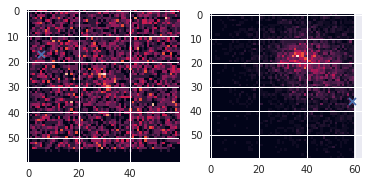

In [132]:
plot(field_image)

In [133]:
def filter_layer(im, l = [1.0, 2.5, 5.0]):
    " return im filtered by the l filters"
    
    return np.stack([ndimage.filters.gaussian_filter(im, l) for l in l])

(3, 60, 60, 60, 60)
[ 53 -54   2  -1]


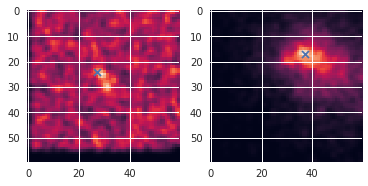

[ 53 -54   2  -1]


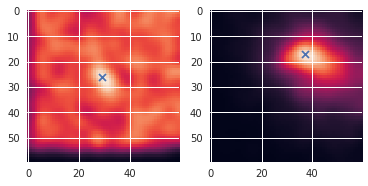

[ 53 -54   2  -1]


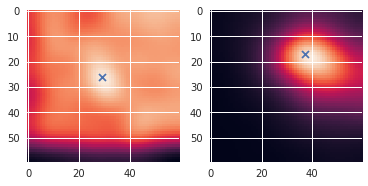

In [134]:
filtered_ims = filter_layer(field_image)
print filtered_ims.shape
for im in filtered_ims:
    plot(im)

1 ********************
[ 53 -54   2  -2]


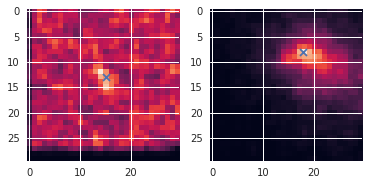

[ 53 -54   2  -2]


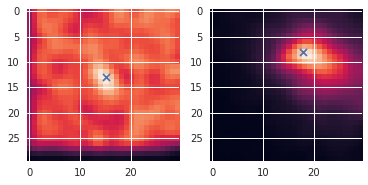

[ 53 -54   2  -2]


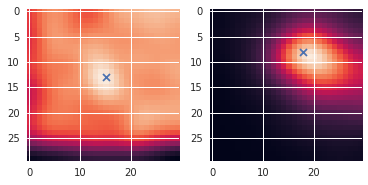

2 ********************
[ 56 -54   0   0]


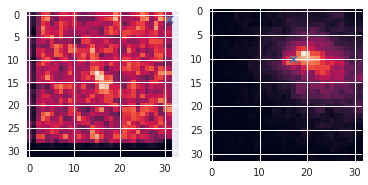

[ 53 -54   1  -1]


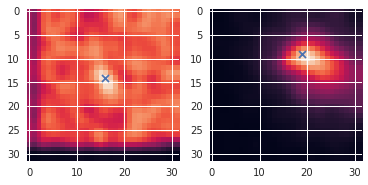

[ 53 -54   2   0]


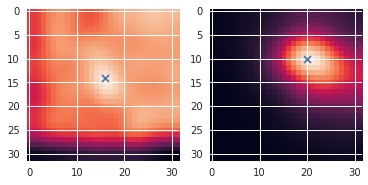

3 ********************
[ 55 -54   0   0]


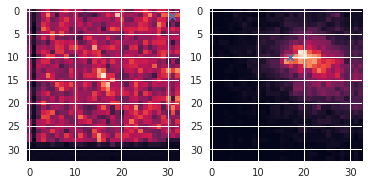

[ 53 -54   2   0]


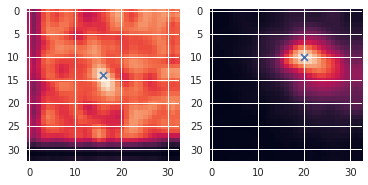

[ 53 -54   2   0]


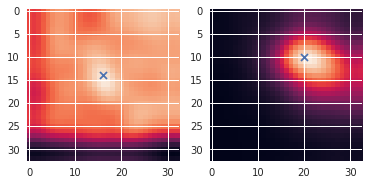

4 ********************
[ 53 -54   2   0]


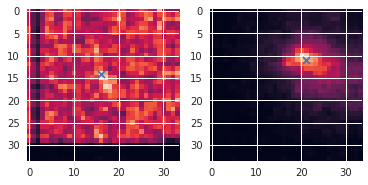

[ 53 -54   1  -1]


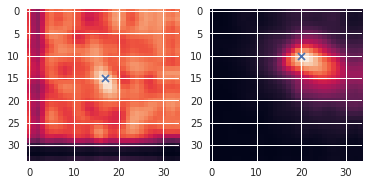

[ 53 -54   2   0]


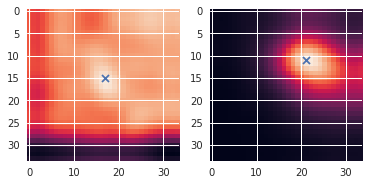

5 ********************
[ 53 -54   2   0]


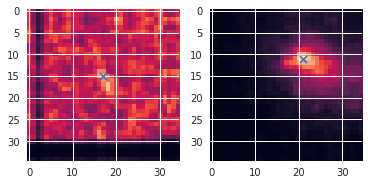

[ 53 -54   2   0]


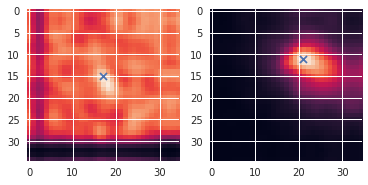

[ 53 -54   2   0]


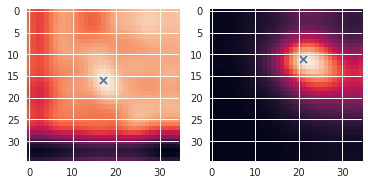

In [135]:
for i in xrange(1,6):
    print i, '*'*20
    coeffs = []
    for fi in filtered_ims:
        coeff = pywt.dwtn(fi, 'bior%d.%d'%(i,i))
        coeffs.append(coeff)
        #plot(coeff['aaaa'])

    for coeff in coeffs:
        plot(coeff['aaaa'])

In [136]:
true_dwarf = pd.read_csv('dgaia_ret_ii_dwarf.txt')

In [137]:
dwarf_field = np.c_[true_dwarf['ra'].as_matrix(), true_dwarf['dec'].as_matrix(), true_dwarf['pmra'].as_matrix(), true_dwarf['pmdec'].as_matrix()]

/afs/slac.stanford.edu/u/ki/swmclau2/.local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [138]:
dwarf_field = dwarf_field[np.logical_and(dwarf_field[:,2] >= vra_min, dwarf_field[:,2] <= vra_max)]
dwarf_field = dwarf_field[np.logical_and(dwarf_field[:,3] >= vdec_min, dwarf_field[:,3] <= vdec_max)]

In [139]:
full_field = full_field[np.logical_and(full_field[:,2] >= vra_min, full_field[:,2] <= vra_max)]
full_field = full_field[np.logical_and(full_field[:,3] >= vdec_min, full_field[:,3] <= vdec_max)]

In [140]:
dwarf_field.mean(axis = 0)

array([ 53.94522908, -54.03468842,   3.53348143,   2.09387601])

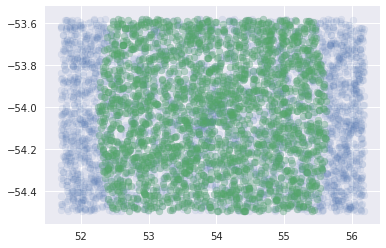

In [141]:
plt.scatter(full_field[:,0], full_field[:,1], alpha = 0.1)
plt.scatter(dwarf_field[:,0], dwarf_field[:,1], alpha = 0.3)

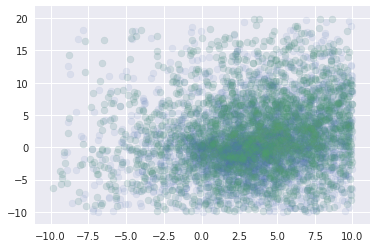

In [142]:
plt.scatter(full_field[:,2], full_field[:,3], alpha = 0.1)
plt.scatter(dwarf_field[:,2], dwarf_field[:,3], alpha = 0.1)

In [143]:
def wavelet_layer(im, wavlets = ['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1'\
                                 , 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8']):
    all_outputs = []
    for wv in wavlets:
        LL, (LH, HL, HH) = pywt.dwt2(im, wv)
        all_outputs.append(np.stack([LL, LH, HL, HH]))
    return all_outputs

In [144]:
max_pos = ndimage.measurements.maximum_position(LL)

NameError: name 'LL' is not defined

In [ ]:
plt.scatter(max_pos[0], max_pos[1])
plt.imshow(LL.T)

In [ ]:
max_pos

In [ ]:
mu_ufdg